# Description of experiment

All layers in pretrained models are not freezed

# Imports

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
import glob
import shutil
from collections import Counter
import random
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
from tqdm import tqdm

import sklearn.metrics

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms

In [2]:
CORE_PATH = "../"
ORIG_PATH = f"{CORE_PATH}/emotions"
SAVE_LOGS_PATH = f"{CORE_PATH}/missclassified"
SAVE_MODELS_PATH = f"{CORE_PATH}/models/experiment_with_no_freeze"

# EDA

In [3]:
data = ImageFolder(ORIG_PATH)
data

Dataset ImageFolder
    Number of datapoints: 496
    Root location: ..//emotions

In [4]:
emotions = os.listdir(ORIG_PATH)
emotions

['anger', 'contempt', 'disgust', 'fear', 'joy', 'sadness', 'wonder']

In [5]:
class_to_idx = data.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

class_to_idx

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'joy': 4,
 'sadness': 5,
 'wonder': 6}

In [6]:
def get_distribution_plot(targets: list, title="Number of images"):
    primary_distribution = Counter(targets)
    sorted_values = sorted(primary_distribution)

    fig = go.Figure(
        go.Bar(
            x=[idx_to_class[x] for x in sorted_values],
            y=[primary_distribution[x] for x in sorted_values],
        )
    )
    fig.update_layout(
        width=600,
        height=400,
        title=title
    )
    fig.show()

In [7]:
get_distribution_plot(data.targets)

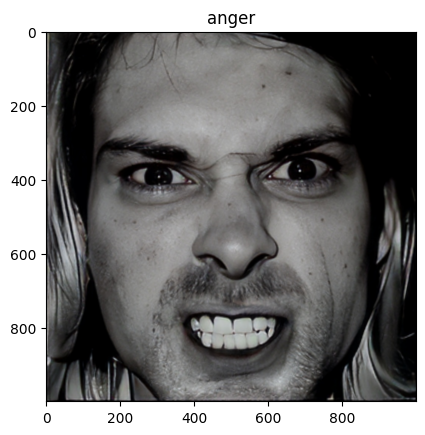

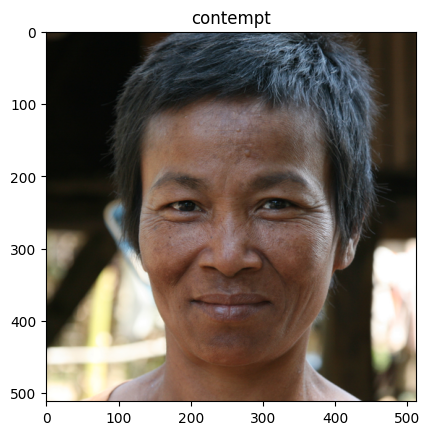

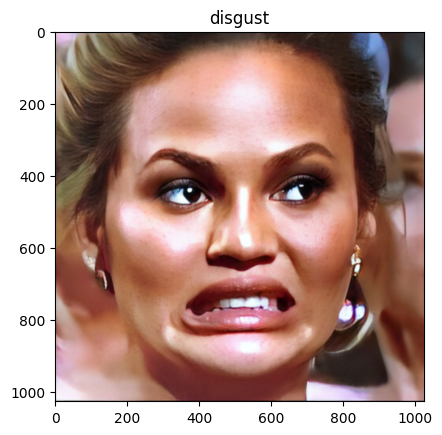

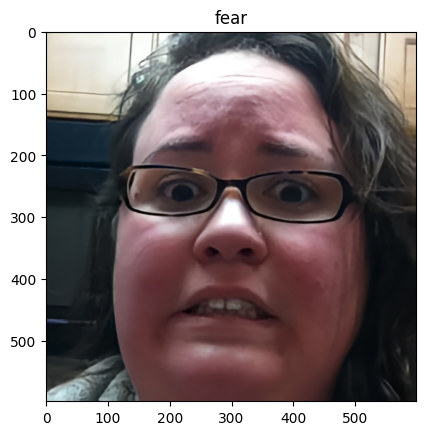

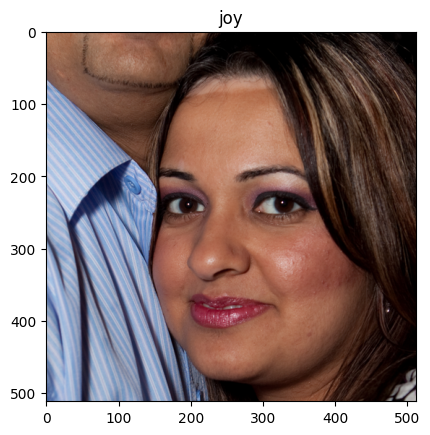

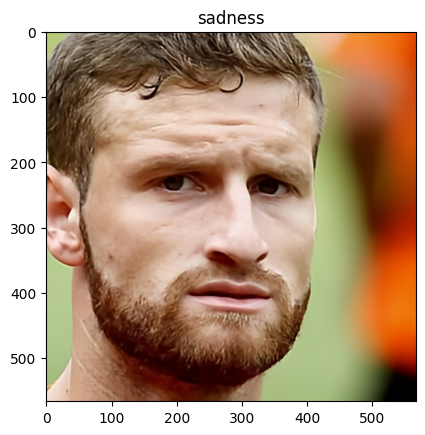

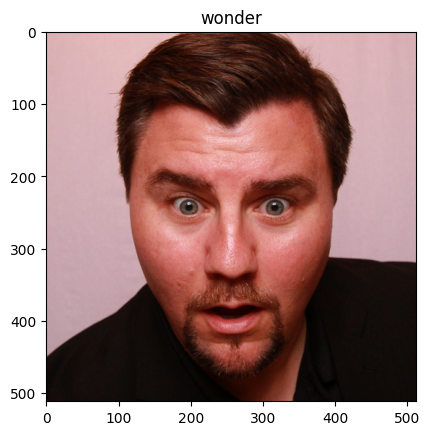

In [8]:
image_index = {x: np.random.choice(np.where(np.array(data.targets) == x)[0])
               for x in idx_to_class.keys()}

for class_id, data_id in image_index.items():
    plt.imshow(data[data_id][0])
    plt.title(f"{idx_to_class[class_id]}")
    plt.show()

# Data Splitting

In [9]:
torch.manual_seed(0)

train_size = 0.75
val_size = 0.1
test_size = 1 - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(
    data, [train_size, val_size, test_size]
)

In [10]:
len(train_data), len(val_data), len(test_data)

(373, 49, 74)

In [11]:
get_distribution_plot(np.array(data.targets)[train_data.indices],
                      "Train distribution")

In [12]:
get_distribution_plot(np.array(data.targets)[val_data.indices],
                      "Val distribution")

In [13]:
get_distribution_plot(np.array(data.targets)[test_data.indices],
                      "Test distribution")

# Setup Datasets and DataLoaders

In [14]:
class EmotionsDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.targets = [x for x in np.array(data.dataset.targets)[data.indices]]
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        if self.transforms is not None:
            image = self.transforms(image)
        return image, label

In [15]:
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomGrayscale(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

inf_transforms = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

train_dataset = EmotionsDataset(train_data, train_transforms)
val_dataset = EmotionsDataset(val_data, inf_transforms)
test_dataset = EmotionsDataset(test_data, inf_transforms)

In [16]:
len(train_dataset) + len(val_dataset) + len(test_dataset)

496

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


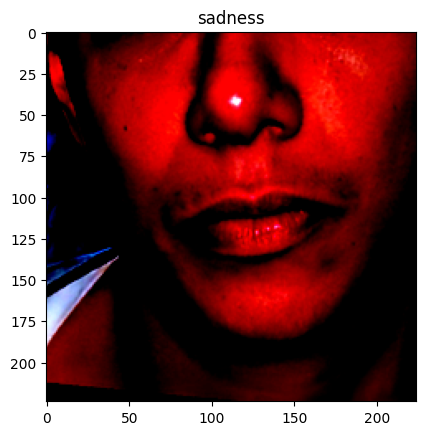

In [17]:
a = random.randint(0, len(train_dataset) - 1)

plt.title(idx_to_class[train_dataset[a][1]])
plt.imshow(train_dataset[a][0].permute(1, 2, 0))

In [18]:
def get_loader(dataset: EmotionsDataset, BATCH_SIZE=16):
    distrib = Counter(dataset.targets)
    class_weights = {x: len(dataset) / distrib[x] for x in distrib.keys()}
    sample_weights = [class_weights[x] for x in dataset.targets]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    return DataLoader(dataset, BATCH_SIZE, sampler=sampler)

# Utility functions

In [19]:
def get_f1_score(true, pred):
    return sklearn.metrics.f1_score(true, pred, average="micro")

In [20]:
class EarlyStopping():
    def __init__(self, patience=4):
        self.last_value = 1_000_000
        self.current_patience = 0
        self.patience = patience

    def __call__(self, new_value) -> bool:
        if new_value > self.last_value:
            self.current_patience += 1
        else:
            self.current_patience = 0
        self.last_value = new_value
        if self.current_patience > self.patience:
            return True
        return False

In [21]:
def train_model(
    model,
    train_loader,
    val_loader,
    epochs,
    criterion,
    optimizer,
    device,
    best_model_path: str,
    scheduler=None,
    early_stopping: EarlyStopping = None
):
    model.to(device)
    train_loss = []
    val_loss = []
    best_loss = 1_000_000

    for step, epoch in enumerate(range(epochs)):
        loss_per_batch = 0.0
        train_batch_f1_score = []
        val_batch_f1_score = []

        model.train()
        for image, label in tqdm(train_loader):
            optimizer.zero_grad()
            image, label = image.to(device), label.to(device)

            output = model(image)
            output_pred = output.max(1)[1].data  # get the predicted class
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            loss_per_batch += loss.item() * output.shape[0]
            train_batch_f1_score.append(get_f1_score(label.cpu(), output_pred.cpu().numpy()))

        train_loss.append(loss_per_batch / len(train_loader.dataset))

        if scheduler:
            scheduler.step()

        model.eval()
        with torch.no_grad():
            loss_per_batch = 0.0
            for image, label in val_loader:
                image, label = image.to(device), label.to(device)

                output = model(image)
                output_pred = output.max(1)[1].data
                loss = criterion(output, label)

                loss_per_batch += loss.item() * output.shape[0]
                val_batch_f1_score.append(get_f1_score(label.cpu(), output_pred.cpu().numpy()))

            val_loss.append(loss_per_batch / len(val_loader.dataset))

        print(f"EPOCH: {step + 1}, train_loss: {train_loss[step]}, val_loss: {val_loss[step]}")
        print(f"train_f1: {np.mean(train_batch_f1_score)}, val_f1: {np.mean(val_batch_f1_score)}")
        print()

        if val_loss[step] < best_loss:
            best_loss = val_loss[step]
            torch.save(model.state_dict(), best_model_path)

        if early_stopping is not None:
            need_to_stop = early_stopping(val_loss[step])
            if need_to_stop is True:
                print("Early Stopping!")
                return train_loss, val_loss

    return train_loss, val_loss

In [22]:
def test_model(model, loader, device):
    model.eval()
    test_f1_score = []
    for image, label in loader:
        output = model(image.to(device))
        output_pred = output.max(1)[1].data
        test_f1_score.append(get_f1_score(label.cpu(), output_pred.cpu().numpy()))

    print(np.mean(test_f1_score))

In [23]:
# source: https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        other_class = [x for x in unique_class if x != per_class]
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]
        roc_auc = sklearn.metrics.roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

def get_metrics_report(true, pred):
    return {
        "Accuracy": sklearn.metrics.accuracy_score(true, pred),
        "Precision_macro": sklearn.metrics.precision_score(true, pred, average='macro'),
        "Precision_micro": sklearn.metrics.precision_score(true, pred, average='micro'),
        "Recall_macro": sklearn.metrics.recall_score(true, pred, average='macro'),
        "Recall_micro": sklearn.metrics.recall_score(true, pred, average='micro'),
        "ROC_AUC": roc_auc_score_multiclass(true, pred)
    }

In [24]:
def get_classification_report(true, pred):
    t, p = np.array(true), np.array(pred)
    for _class in set(t):
        indices_class = np.where(t == _class)[0]
        correct = t[indices_class]
        predicted = p[indices_class]

        print(f"{idx_to_class[_class]} emotion")
        print(f"Overall images: {len(indices_class)}")
        print(f"Correctly predicted {(correct == predicted).sum()}/{len(indices_class)}")
        print()

In [25]:
def get_mistaken_images_report(path_list, actual, pred, model_name):
    for ind, (actual, pred) in enumerate(zip(actual, pred)):
        if actual == pred:
            continue

        image = Image.open(path_list[ind]).convert("RGB")
        save_path = f'{SAVE_LOGS_PATH}/{model_name}/'
        Path(save_path).mkdir(parents=True, exist_ok=True)

        plt.title(f"True: {idx_to_class[actual]}, Predicted: {idx_to_class[pred]}")
        plt.imshow(image)
        plt.savefig(f'{save_path}image_{ind}.png')
        plt.show()

In [26]:
def inference_model(model, path_list, device):
    model.to(device)
    model.eval()

    pred = []
    for f in path_list:
        image = Image.open(f).convert('RGB')
        tensor = inf_transforms(image).to(device)
        predicted = model(tensor.unsqueeze(0)).max(1)[1].data.cpu().item()
        pred.append(predicted)

    return pred

# Training setup

In [27]:
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

In [28]:
train_loader = get_loader(train_dataset, BATCH_SIZE)
val_loader = DataLoader(val_dataset, BATCH_SIZE)
test_loader = DataLoader(test_dataset, BATCH_SIZE)

# RESNET50

In [29]:
from torchvision.models import resnet50, ResNet50_Weights

In [30]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
classifier = nn.Sequential(nn.Linear(model.fc.in_features, 512),
                           nn.ReLU(),
                           nn.Dropout(),
                           nn.Linear(512, len(emotions)))
model.fc = classifier
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [31]:
loss_train, loss_val = train_model(
    model,
    train_loader,
    val_loader,
    EPOCHS,
    criterion,
    optimizer,
    device,
    "best_resnet50_100.pt",
    early_stopping=EarlyStopping()
)

100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


EPOCH: 1, train_loss: 1.9140729169104118, val_loss: 7.397336697091862
train_f1: 0.2015625, val_f1: 0.15625



100%|██████████| 24/24 [00:10<00:00,  2.38it/s]


EPOCH: 2, train_loss: 1.8812947615222062, val_loss: 2.138517749552824
train_f1: 0.2203125, val_f1: 0.15625



100%|██████████| 24/24 [00:09<00:00,  2.62it/s]


EPOCH: 3, train_loss: 1.7821100132075456, val_loss: 2.337181130234076
train_f1: 0.32916666666666666, val_f1: 0.21875



100%|██████████| 24/24 [00:09<00:00,  2.64it/s]


EPOCH: 4, train_loss: 1.78014995840855, val_loss: 1.8822684628622872
train_f1: 0.3026041666666667, val_f1: 0.25



100%|██████████| 24/24 [00:09<00:00,  2.45it/s]


EPOCH: 5, train_loss: 1.7339949831566286, val_loss: 2.3381484576634
train_f1: 0.284375, val_f1: 0.1875



100%|██████████| 24/24 [00:09<00:00,  2.55it/s]


EPOCH: 6, train_loss: 1.6680910101524946, val_loss: 1.7940066298659967
train_f1: 0.33177083333333335, val_f1: 0.296875



100%|██████████| 24/24 [00:09<00:00,  2.53it/s]


EPOCH: 7, train_loss: 1.601731016233204, val_loss: 1.9677218369075231
train_f1: 0.4109375, val_f1: 0.1875



100%|██████████| 24/24 [00:09<00:00,  2.55it/s]


EPOCH: 8, train_loss: 1.612947514485418, val_loss: 2.321662406532132
train_f1: 0.3729166666666666, val_f1: 0.25



100%|██████████| 24/24 [00:09<00:00,  2.46it/s]


EPOCH: 9, train_loss: 1.5916995541979098, val_loss: 2.2499391740682175
train_f1: 0.36302083333333335, val_f1: 0.09375



100%|██████████| 24/24 [00:09<00:00,  2.48it/s]


EPOCH: 10, train_loss: 1.5351045796442926, val_loss: 1.88225676088917
train_f1: 0.3651041666666666, val_f1: 0.15625



100%|██████████| 24/24 [00:09<00:00,  2.59it/s]


EPOCH: 11, train_loss: 1.5163671356743207, val_loss: 2.375064956898592
train_f1: 0.42343749999999997, val_f1: 0.25



100%|██████████| 24/24 [00:08<00:00,  2.69it/s]


EPOCH: 12, train_loss: 1.6195668336852946, val_loss: 2.1824551601799165
train_f1: 0.38645833333333335, val_f1: 0.296875



100%|██████████| 24/24 [00:09<00:00,  2.52it/s]


EPOCH: 13, train_loss: 1.5696546264372306, val_loss: 1.5360026164930694
train_f1: 0.3692708333333334, val_f1: 0.296875



100%|██████████| 24/24 [00:09<00:00,  2.66it/s]


EPOCH: 14, train_loss: 1.513201330686063, val_loss: 1.7800262071648423
train_f1: 0.3958333333333333, val_f1: 0.328125



100%|██████████| 24/24 [00:09<00:00,  2.62it/s]


EPOCH: 15, train_loss: 1.4629077121974956, val_loss: 1.3890640565327235
train_f1: 0.45156250000000003, val_f1: 0.296875



100%|██████████| 24/24 [00:08<00:00,  2.89it/s]


EPOCH: 16, train_loss: 1.4204901987362164, val_loss: 1.4998409772405819
train_f1: 0.47291666666666665, val_f1: 0.28125



100%|██████████| 24/24 [00:08<00:00,  2.82it/s]


EPOCH: 17, train_loss: 1.3701926095875594, val_loss: 1.4146211001337792
train_f1: 0.45937500000000003, val_f1: 0.328125



100%|██████████| 24/24 [00:09<00:00,  2.64it/s]


EPOCH: 18, train_loss: 1.279380209484305, val_loss: 1.7729053448657601
train_f1: 0.5286458333333334, val_f1: 0.28125



100%|██████████| 24/24 [00:08<00:00,  2.71it/s]


EPOCH: 19, train_loss: 1.3106588022958177, val_loss: 1.4813948894033626
train_f1: 0.5276041666666667, val_f1: 0.25



100%|██████████| 24/24 [00:09<00:00,  2.66it/s]


EPOCH: 20, train_loss: 1.378495268144173, val_loss: 1.5439593597334258
train_f1: 0.48541666666666666, val_f1: 0.3125



100%|██████████| 24/24 [00:08<00:00,  2.75it/s]


EPOCH: 21, train_loss: 1.3077550068617507, val_loss: 1.5665889224227594
train_f1: 0.49114583333333334, val_f1: 0.34375



100%|██████████| 24/24 [00:09<00:00,  2.50it/s]


EPOCH: 22, train_loss: 1.252171044375238, val_loss: 1.6884647145563243
train_f1: 0.5145833333333333, val_f1: 0.21875



100%|██████████| 24/24 [00:08<00:00,  2.84it/s]


EPOCH: 23, train_loss: 1.3985528741381443, val_loss: 2.07678391982098
train_f1: 0.45416666666666666, val_f1: 0.21875



100%|██████████| 24/24 [00:08<00:00,  2.78it/s]


EPOCH: 24, train_loss: 1.321464471459069, val_loss: 2.09561342609172
train_f1: 0.48020833333333335, val_f1: 0.234375

Early Stopping!


In [32]:
torch.save(model.state_dict(), f"{SAVE_MODELS_PATH}/resnet50_100_train.pt")
shutil.copyfile("best_resnet50_100.pt", f"{SAVE_MODELS_PATH}/best_resnet50_100.pt")

'..//models/experiment_with_no_freeze/best_resnet50_100.pt'

In [33]:
best = resnet50(weights=ResNet50_Weights.DEFAULT)
classifier = nn.Sequential(nn.Linear(best.fc.in_features, 512),
                           nn.ReLU(),
                           nn.Dropout(),
                           nn.Linear(512, len(emotions)))
best.fc = classifier
best.load_state_dict(torch.load(f"{SAVE_MODELS_PATH}/best_resnet50_100.pt"))
best.eval()
best = best.to(device)

In [34]:
test_model(model, test_loader, device)

0.2125


In [35]:
test_model(best, test_loader, device)

0.3225


In [36]:
not_train_indices = val_data.indices + test_data.indices
inf_images = [data.imgs[x][0] for x in not_train_indices]
inf_labels = [data.imgs[x][1] for x in not_train_indices]

preds = inference_model(model, inf_images, device)
get_metrics_report(inf_labels, preds)

{'Accuracy': 0.2601626016260163,
 'Precision_macro': 0.27083333333333337,
 'Precision_micro': 0.2601626016260163,
 'Recall_macro': 0.2906710582650432,
 'Recall_micro': 0.2601626016260163,
 'ROC_AUC': {0: 0.5117955439056356,
  1: 0.6189271255060729,
  2: 0.665929203539823,
  3: 0.6423076923076924,
  4: 0.6361650485436894,
  5: 0.4842857142857143,
  6: 0.5306030603060305}}

In [37]:
get_classification_report(inf_labels, preds)

anger emotion
Overall images: 14
Correctly predicted 2/14

contempt emotion
Overall images: 19
Correctly predicted 10/19

disgust emotion
Overall images: 10
Correctly predicted 5/10

fear emotion
Overall images: 13
Correctly predicted 5/13

joy emotion
Overall images: 20
Correctly predicted 7/20

sadness emotion
Overall images: 25
Correctly predicted 1/25

wonder emotion
Overall images: 22
Correctly predicted 2/22



In [ ]:
get_mistaken_images_report(inf_images, inf_labels, preds, "resnet50_100")

# RESNET18

In [38]:
from torchvision.models import resnet18, ResNet18_Weights

In [39]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
classifier = nn.Sequential(nn.Linear(model.fc.in_features, 512),
                           nn.ReLU(),
                           nn.Dropout(),
                           nn.Linear(512, len(emotions)))
model.fc = classifier
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [40]:
loss_train, loss_val = train_model(
    model,
    train_loader,
    val_loader,
    EPOCHS,
    criterion,
    optimizer,
    device,
    "best_resnet18_100.pt",
    early_stopping=EarlyStopping(patience=3)
)

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:07<00:00,  3.17it/s]


EPOCH: 1, train_loss: 1.965598147292559, val_loss: 2.220077417334732
train_f1: 0.26875, val_f1: 0.421875



100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


EPOCH: 2, train_loss: 1.971865293167871, val_loss: 1.8569003124626315
train_f1: 0.21458333333333335, val_f1: 0.1875



100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


EPOCH: 3, train_loss: 1.744558753660473, val_loss: 1.910330358816653
train_f1: 0.2864583333333333, val_f1: 0.171875



100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


EPOCH: 4, train_loss: 1.6740016576112435, val_loss: 1.7538417407444544
train_f1: 0.3333333333333333, val_f1: 0.421875



100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


EPOCH: 5, train_loss: 1.6570483382202026, val_loss: 1.7128878661564417
train_f1: 0.34791666666666665, val_f1: 0.1875



100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


EPOCH: 6, train_loss: 1.7024728507203009, val_loss: 2.993451867784773
train_f1: 0.3125, val_f1: 0.171875



100%|██████████| 24/24 [00:07<00:00,  3.12it/s]


EPOCH: 7, train_loss: 1.7284303305935285, val_loss: 2.0601771145450827
train_f1: 0.3229166666666667, val_f1: 0.171875



100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


EPOCH: 8, train_loss: 1.6185025884382847, val_loss: 1.5034258073689986
train_f1: 0.3625, val_f1: 0.265625



100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


EPOCH: 9, train_loss: 1.6310997367224809, val_loss: 2.202144610638521
train_f1: 0.3260416666666667, val_f1: 0.4375



100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


EPOCH: 10, train_loss: 1.607479627586242, val_loss: 1.8495481452163385
train_f1: 0.3546875, val_f1: 0.21875



100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


EPOCH: 11, train_loss: 1.5360325983957694, val_loss: 2.1500552758878593
train_f1: 0.41770833333333335, val_f1: 0.4375



100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


EPOCH: 12, train_loss: 1.692377041875517, val_loss: 1.6287799124815026
train_f1: 0.2890625, val_f1: 0.234375



100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


EPOCH: 13, train_loss: 1.5716689872997376, val_loss: 1.8052230002928753
train_f1: 0.4083333333333334, val_f1: 0.453125



100%|██████████| 24/24 [00:07<00:00,  3.17it/s]


EPOCH: 14, train_loss: 1.5408785288838855, val_loss: 1.6501684772725007
train_f1: 0.39218749999999997, val_f1: 0.265625



100%|██████████| 24/24 [00:07<00:00,  3.12it/s]


EPOCH: 15, train_loss: 1.5165887866518772, val_loss: 1.565224747268521
train_f1: 0.4171875, val_f1: 0.53125



100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


EPOCH: 16, train_loss: 1.6208840790766494, val_loss: 1.8616788533269142
train_f1: 0.36302083333333335, val_f1: 0.234375



100%|██████████| 24/24 [00:07<00:00,  3.16it/s]


EPOCH: 17, train_loss: 1.6261805804101774, val_loss: 1.5326166006983544
train_f1: 0.3822916666666667, val_f1: 0.3125



100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


EPOCH: 18, train_loss: 1.490041610382837, val_loss: 1.656181846346174
train_f1: 0.3828125, val_f1: 0.28125



100%|██████████| 24/24 [00:07<00:00,  3.16it/s]


EPOCH: 19, train_loss: 1.5919226320115873, val_loss: 1.5810420586138356
train_f1: 0.37916666666666665, val_f1: 0.484375



100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


EPOCH: 20, train_loss: 1.5077539059176202, val_loss: 1.3256898364242242
train_f1: 0.3859375, val_f1: 0.328125



100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


EPOCH: 21, train_loss: 1.4888388017547034, val_loss: 1.7635339522848323
train_f1: 0.38645833333333335, val_f1: 0.265625



100%|██████████| 24/24 [00:07<00:00,  3.00it/s]


EPOCH: 22, train_loss: 1.4414093181211252, val_loss: 1.632557100179244
train_f1: 0.375, val_f1: 0.28125



100%|██████████| 24/24 [00:08<00:00,  2.69it/s]


EPOCH: 23, train_loss: 1.4452892254249021, val_loss: 1.5174532909782565
train_f1: 0.4015625, val_f1: 0.25



100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


EPOCH: 24, train_loss: 1.4720879502334798, val_loss: 1.6986474577261477
train_f1: 0.3572916666666666, val_f1: 0.265625



100%|██████████| 24/24 [00:07<00:00,  3.18it/s]


EPOCH: 25, train_loss: 1.506682438760916, val_loss: 1.5072346122897402
train_f1: 0.45937500000000003, val_f1: 0.296875



100%|██████████| 24/24 [00:08<00:00,  2.92it/s]


EPOCH: 26, train_loss: 1.4409001583068684, val_loss: 1.3483804585982342
train_f1: 0.43645833333333334, val_f1: 0.34375



100%|██████████| 24/24 [00:08<00:00,  2.98it/s]


EPOCH: 27, train_loss: 1.3934984996555317, val_loss: 1.5262397892621098
train_f1: 0.42343749999999997, val_f1: 0.3125



100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


EPOCH: 28, train_loss: 1.4557674404123833, val_loss: 1.6309825498230603
train_f1: 0.421875, val_f1: 0.296875



100%|██████████| 24/24 [00:07<00:00,  3.17it/s]


EPOCH: 29, train_loss: 1.5611457792747436, val_loss: 1.9712570735386439
train_f1: 0.40989583333333335, val_f1: 0.234375



100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


EPOCH: 30, train_loss: 1.5308306258741078, val_loss: 1.5770417768128064
train_f1: 0.3807291666666666, val_f1: 0.25



100%|██████████| 24/24 [00:08<00:00,  2.89it/s]


EPOCH: 31, train_loss: 1.435166984716625, val_loss: 1.6669049068373076
train_f1: 0.41250000000000003, val_f1: 0.234375



100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


EPOCH: 32, train_loss: 1.387271446453023, val_loss: 1.5675279169666523
train_f1: 0.409375, val_f1: 0.265625



100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


EPOCH: 33, train_loss: 1.44810119774642, val_loss: 1.471589713680501
train_f1: 0.45677083333333335, val_f1: 0.53125



100%|██████████| 24/24 [00:07<00:00,  3.06it/s]


EPOCH: 34, train_loss: 1.3832349652579259, val_loss: 1.4525032432711855
train_f1: 0.46510416666666665, val_f1: 0.296875



100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


EPOCH: 35, train_loss: 1.3528431574077453, val_loss: 1.5645358659783188
train_f1: 0.45677083333333335, val_f1: 0.296875



100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


EPOCH: 36, train_loss: 1.292435898218334, val_loss: 1.8161954879760742
train_f1: 0.47031249999999997, val_f1: 0.203125



100%|██████████| 24/24 [00:07<00:00,  3.03it/s]


EPOCH: 37, train_loss: 1.3438771272792254, val_loss: 1.574569439401432
train_f1: 0.5010416666666667, val_f1: 0.28125



100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


EPOCH: 38, train_loss: 1.4179055032397723, val_loss: 1.536532805890453
train_f1: 0.4302083333333333, val_f1: 0.515625



100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


EPOCH: 39, train_loss: 1.3683287148181618, val_loss: 1.4888003383363997
train_f1: 0.42552083333333335, val_f1: 0.296875



100%|██████████| 24/24 [00:07<00:00,  3.01it/s]


EPOCH: 40, train_loss: 1.3784332946542122, val_loss: 1.6047727429136938
train_f1: 0.4375, val_f1: 0.25



100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


EPOCH: 41, train_loss: 1.2906964899068223, val_loss: 1.6767159201660935
train_f1: 0.453125, val_f1: 0.53125



100%|██████████| 24/24 [00:07<00:00,  3.13it/s]


EPOCH: 42, train_loss: 1.4306778083218326, val_loss: 1.9187922088467344
train_f1: 0.44687499999999997, val_f1: 0.21875



100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


EPOCH: 43, train_loss: 1.33907743145889, val_loss: 1.6365953537882592
train_f1: 0.49374999999999997, val_f1: 0.3125



100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


EPOCH: 44, train_loss: 1.3519881477944014, val_loss: 2.098981662672393
train_f1: 0.4380208333333333, val_f1: 0.265625



100%|██████████| 24/24 [00:07<00:00,  3.07it/s]


EPOCH: 45, train_loss: 1.357622200937757, val_loss: 1.5444242662313032
train_f1: 0.4166666666666667, val_f1: 0.28125



100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


EPOCH: 46, train_loss: 1.3005516426812547, val_loss: 1.750082015991211
train_f1: 0.4979166666666666, val_f1: 0.296875



100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


EPOCH: 47, train_loss: 1.2226475502786305, val_loss: 1.7945661611702977
train_f1: 0.5145833333333333, val_f1: 0.53125



100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


EPOCH: 48, train_loss: 1.2083060466572042, val_loss: 1.480396523767588
train_f1: 0.540625, val_f1: 0.515625



100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


EPOCH: 49, train_loss: 1.273647852781311, val_loss: 2.088318425781873
train_f1: 0.5171875, val_f1: 0.21875



100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


EPOCH: 50, train_loss: 1.272556754922739, val_loss: 1.5382403597539784
train_f1: 0.47760416666666666, val_f1: 0.28125



100%|██████████| 24/24 [00:07<00:00,  3.12it/s]


EPOCH: 51, train_loss: 1.19468697625894, val_loss: 1.7294884798478107
train_f1: 0.5458333333333333, val_f1: 0.234375



100%|██████████| 24/24 [00:08<00:00,  2.97it/s]


EPOCH: 52, train_loss: 1.167676206887887, val_loss: 1.8523167882646834
train_f1: 0.49843750000000003, val_f1: 0.578125



100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


EPOCH: 53, train_loss: 1.338489391528889, val_loss: 2.186765960284642
train_f1: 0.49895833333333334, val_f1: 0.46875



100%|██████████| 24/24 [00:07<00:00,  3.17it/s]


EPOCH: 54, train_loss: 1.2097730029364373, val_loss: 1.4438044051734769
train_f1: 0.5083333333333333, val_f1: 0.296875



100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


EPOCH: 55, train_loss: 1.1409674481795875, val_loss: 1.2844460424111814
train_f1: 0.55625, val_f1: 0.421875



100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


EPOCH: 56, train_loss: 1.2412764815159203, val_loss: 1.6912536475123192
train_f1: 0.5109374999999999, val_f1: 0.296875



100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


EPOCH: 57, train_loss: 1.116380673311351, val_loss: 1.6093877334983981
train_f1: 0.5505208333333333, val_f1: 0.296875



100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


EPOCH: 58, train_loss: 1.1748169929028836, val_loss: 1.600827693939209
train_f1: 0.5458333333333333, val_f1: 0.28125



100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


EPOCH: 59, train_loss: 1.0971468193281753, val_loss: 1.5021971683112942
train_f1: 0.5671875000000001, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


EPOCH: 60, train_loss: 1.196006689889821, val_loss: 1.7667738126248729
train_f1: 0.5328125, val_f1: 0.359375



100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


EPOCH: 61, train_loss: 1.242530211047257, val_loss: 1.442751687400195
train_f1: 0.5182291666666666, val_f1: 0.59375



100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


EPOCH: 62, train_loss: 1.2291801480761162, val_loss: 2.0601543504364637
train_f1: 0.5421874999999999, val_f1: 0.3125



100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


EPOCH: 63, train_loss: 1.1409918210461696, val_loss: 1.6840373739904286
train_f1: 0.5848958333333333, val_f1: 0.3125



100%|██████████| 24/24 [00:08<00:00,  2.97it/s]


EPOCH: 64, train_loss: 1.123599040923745, val_loss: 2.1684965503459073
train_f1: 0.5505208333333333, val_f1: 0.28125



100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


EPOCH: 65, train_loss: 1.2130509953716166, val_loss: 1.8259897767281046
train_f1: 0.5359375000000001, val_f1: 0.296875



100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


EPOCH: 66, train_loss: 1.1457441137559292, val_loss: 1.5375888007027763
train_f1: 0.5744791666666667, val_f1: 0.359375



100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


EPOCH: 67, train_loss: 1.0656107600189086, val_loss: 1.4044612816401891
train_f1: 0.5791666666666667, val_f1: 0.625



100%|██████████| 24/24 [00:07<00:00,  3.11it/s]


EPOCH: 68, train_loss: 1.1515447505357759, val_loss: 1.547034358491703
train_f1: 0.553125, val_f1: 0.625



100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


EPOCH: 69, train_loss: 1.0867527234330574, val_loss: 1.4003409220247853
train_f1: 0.5817708333333333, val_f1: 0.34375



100%|██████████| 24/24 [00:07<00:00,  3.08it/s]


EPOCH: 70, train_loss: 1.1820474629747324, val_loss: 1.5906331928408877
train_f1: 0.5796875, val_f1: 0.3125



100%|██████████| 24/24 [00:08<00:00,  2.95it/s]


EPOCH: 71, train_loss: 1.0462601955071211, val_loss: 1.4426025857730789
train_f1: 0.6244791666666667, val_f1: 0.328125



100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


EPOCH: 72, train_loss: 1.083291665478622, val_loss: 1.48948927314914
train_f1: 0.5682291666666667, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.08it/s]


EPOCH: 73, train_loss: 0.9580921733667, val_loss: 2.0042226728127925
train_f1: 0.6546875, val_f1: 0.625



100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


EPOCH: 74, train_loss: 1.0748390362026226, val_loss: 1.6492266703625114
train_f1: 0.5822916666666667, val_f1: 0.296875



100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


EPOCH: 75, train_loss: 1.0007209090700737, val_loss: 1.4943819435275332
train_f1: 0.6552083333333333, val_f1: 0.6875



100%|██████████| 24/24 [00:07<00:00,  3.17it/s]


EPOCH: 76, train_loss: 0.946540497742773, val_loss: 1.4326461967156858
train_f1: 0.6578125, val_f1: 0.359375



100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


EPOCH: 77, train_loss: 1.0912751020119593, val_loss: 1.396249272385422
train_f1: 0.5776041666666667, val_f1: 0.640625



100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


EPOCH: 78, train_loss: 1.0334476625631706, val_loss: 1.4383032224616226
train_f1: 0.6265625, val_f1: 0.34375



100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


EPOCH: 79, train_loss: 1.0282287131046162, val_loss: 1.48513240473611
train_f1: 0.5979166666666667, val_f1: 0.328125



100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


EPOCH: 80, train_loss: 0.9265123655265521, val_loss: 1.611389432634626
train_f1: 0.6244791666666667, val_f1: 0.375



100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


EPOCH: 81, train_loss: 1.0302543080843805, val_loss: 1.742188735884063
train_f1: 0.6161458333333333, val_f1: 0.265625

Early Stopping!


In [41]:
torch.save(model.state_dict(), f"{SAVE_MODELS_PATH}/resnet18_100_train.pt")
shutil.copyfile("best_resnet18_100.pt", f"{SAVE_MODELS_PATH}/best_resnet18_100.pt")

'..//models/experiment_with_no_freeze/best_resnet18_100.pt'

In [65]:
best = resnet18(weights=ResNet18_Weights.DEFAULT)
classifier = nn.Sequential(nn.Linear(best.fc.in_features, 512),
                           nn.ReLU(),
                           nn.Dropout(),
                           nn.Linear(512, len(emotions)))
best.fc = classifier
best.load_state_dict(torch.load(f"{SAVE_MODELS_PATH}/best_resnet18_100.pt"))
best.eval()
best = best.to(device)

In [43]:
test_model(model, test_loader, device)

0.39249999999999996


In [66]:
test_model(best, test_loader, device)

0.4575


In [45]:
not_train_indices = val_data.indices + test_data.indices
inf_images = [data.imgs[x][0] for x in not_train_indices]
inf_labels = [data.imgs[x][1] for x in not_train_indices]

preds = inference_model(model, inf_images, device)
get_metrics_report(inf_labels, preds)

{'Accuracy': 0.37398373983739835,
 'Precision_macro': 0.32792578569889497,
 'Precision_micro': 0.37398373983739835,
 'Recall_macro': 0.3540092238588479,
 'Recall_micro': 0.37398373983739835,
 'ROC_AUC': {0: 0.5173656618610747,
  1: 0.5501012145748988,
  2: 0.665929203539823,
  3: 0.5248251748251749,
  4: 0.821601941747573,
  5: 0.543469387755102,
  6: 0.7468496849684968}}

In [67]:
not_train_indices = val_data.indices + test_data.indices
inf_images = [data.imgs[x][0] for x in not_train_indices]
inf_labels = [data.imgs[x][1] for x in not_train_indices]

preds = inference_model(best, inf_images, device)
get_metrics_report(inf_labels, preds)

d:\diploma\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



{'Accuracy': 0.4878048780487805,
 'Precision_macro': 0.4124519372966578,
 'Precision_micro': 0.4878048780487805,
 'Recall_macro': 0.45517084419340054,
 'Recall_micro': 0.4878048780487805,
 'ROC_AUC': {0: 0.5887942332896461,
  1: 0.700657894736842,
  2: 0.5,
  3: 0.8164335664335665,
  4: 0.9063106796116505,
  5: 0.7230612244897959,
  6: 0.5533303330333033}}

In [46]:
get_classification_report(inf_labels, preds)

anger emotion
Overall images: 14
Correctly predicted 1/14

contempt emotion
Overall images: 19
Correctly predicted 3/19

disgust emotion
Overall images: 10
Correctly predicted 5/10

fear emotion
Overall images: 13
Correctly predicted 1/13

joy emotion
Overall images: 20
Correctly predicted 15/20

sadness emotion
Overall images: 25
Correctly predicted 6/25

wonder emotion
Overall images: 22
Correctly predicted 15/22



In [ ]:
get_mistaken_images_report(inf_images, inf_labels, preds, "resnet18_100")

# VGG19

In [47]:
from torchvision.models import vgg19_bn, VGG19_BN_Weights

In [48]:
model = vgg19_bn(weights=VGG19_BN_Weights.DEFAULT)
model.classifier[6] = nn.Sequential(nn.Linear(model.classifier[6].in_features, 512),
                           nn.ReLU(),
                           nn.Dropout(),
                           nn.Linear(512, len(emotions)))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [49]:
loss_train, loss_val = train_model(
    model,
    train_loader,
    val_loader,
    EPOCHS,
    criterion,
    optimizer,
    device,
    "best_vgg19_100.pt",
    early_stopping=EarlyStopping(patience=3)
)

100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


EPOCH: 1, train_loss: 2.0238082447256542, val_loss: 2.1736600934242714
train_f1: 0.11197916666666667, val_f1: 0.078125



100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


EPOCH: 2, train_loss: 1.9360000249847331, val_loss: 2.7104235960512746
train_f1: 0.15364583333333334, val_f1: 0.046875



100%|██████████| 24/24 [00:13<00:00,  1.82it/s]


EPOCH: 3, train_loss: 1.9532938367879422, val_loss: 1.956110796149896
train_f1: 0.19895833333333335, val_f1: 0.40625



100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


EPOCH: 4, train_loss: 1.9584308303393243, val_loss: 1.9632482650328655
train_f1: 0.1640625, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


EPOCH: 5, train_loss: 1.951237374911679, val_loss: 2.2462040599511592
train_f1: 0.14635416666666667, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


EPOCH: 6, train_loss: 1.950969488946746, val_loss: 1.9346366293576298
train_f1: 0.13541666666666666, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


EPOCH: 7, train_loss: 1.949543426567364, val_loss: 1.9428817423022524
train_f1: 0.15989583333333332, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


EPOCH: 8, train_loss: 1.9610192034263714, val_loss: 1.951598629659536
train_f1: 0.12239583333333333, val_f1: 0.09375



100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


EPOCH: 9, train_loss: 1.9455570960492294, val_loss: 2.6314771540310917
train_f1: 0.15364583333333334, val_f1: 0.09375



100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


EPOCH: 10, train_loss: 1.9590505521354982, val_loss: 1.9596912520272392
train_f1: 0.16458333333333333, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


EPOCH: 11, train_loss: 1.965547947717416, val_loss: 1.9400080856011839
train_f1: 0.13854166666666667, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


EPOCH: 12, train_loss: 1.9406031184797312, val_loss: 2.1512065614972795
train_f1: 0.14895833333333333, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.91it/s]


EPOCH: 13, train_loss: 1.9606116450823663, val_loss: 2.2709965803185286
train_f1: 0.15104166666666666, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


EPOCH: 14, train_loss: 1.9646288306719497, val_loss: 1.930746747522938
train_f1: 0.1328125, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


EPOCH: 15, train_loss: 1.943222087126315, val_loss: 1.96547540353269
train_f1: 0.1640625, val_f1: 0.125



100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


EPOCH: 16, train_loss: 1.9693500637688521, val_loss: 2.4576270945218144
train_f1: 0.1125, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


EPOCH: 17, train_loss: 1.9874005407174855, val_loss: 1.9267647217731088
train_f1: 0.15885416666666666, val_f1: 0.109375



100%|██████████| 24/24 [00:13<00:00,  1.83it/s]


EPOCH: 18, train_loss: 1.9466039539981463, val_loss: 2.0148477846262405
train_f1: 0.16145833333333334, val_f1: 0.078125



100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


EPOCH: 19, train_loss: 1.9486765391705183, val_loss: 1.9486844490985482
train_f1: 0.19114583333333335, val_f1: 0.15625



100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


EPOCH: 20, train_loss: 1.9446033041215134, val_loss: 2.023772585148714
train_f1: 0.20364583333333333, val_f1: 0.125



100%|██████████| 24/24 [00:13<00:00,  1.82it/s]


EPOCH: 21, train_loss: 1.9591261330622451, val_loss: 1.9779439799639644
train_f1: 0.1640625, val_f1: 0.109375



100%|██████████| 24/24 [00:13<00:00,  1.80it/s]


EPOCH: 22, train_loss: 1.941663455387862, val_loss: 1.9350399289812361
train_f1: 0.19270833333333334, val_f1: 0.140625



100%|██████████| 24/24 [00:13<00:00,  1.82it/s]


EPOCH: 23, train_loss: 1.9562247694337656, val_loss: 1.9022439572275902
train_f1: 0.1640625, val_f1: 0.140625



100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


EPOCH: 24, train_loss: 1.959167855035204, val_loss: 2.2488385998472875
train_f1: 0.14114583333333333, val_f1: 0.171875



100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


EPOCH: 25, train_loss: 1.9470600509771394, val_loss: 1.9276243545571152
train_f1: 0.17500000000000002, val_f1: 0.09375



100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


EPOCH: 26, train_loss: 1.9565332044545192, val_loss: 1.9380947789367364
train_f1: 0.15885416666666666, val_f1: 0.171875



100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


EPOCH: 27, train_loss: 1.955389639327737, val_loss: 1.9483835040306559
train_f1: 0.1807291666666667, val_f1: 0.140625



100%|██████████| 24/24 [00:13<00:00,  1.82it/s]


EPOCH: 28, train_loss: 1.9672502173814952, val_loss: 1.9400215221911061
train_f1: 0.18229166666666666, val_f1: 0.109375



100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


EPOCH: 29, train_loss: 1.9579718176864747, val_loss: 2.1168519866709805
train_f1: 0.16197916666666667, val_f1: 0.125



100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


EPOCH: 30, train_loss: 1.9483372938217491, val_loss: 2.1054173586319904
train_f1: 0.15104166666666666, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


EPOCH: 31, train_loss: 1.9780991349079653, val_loss: 1.9679109028407507
train_f1: 0.17500000000000002, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


EPOCH: 32, train_loss: 1.95307859402879, val_loss: 1.9568791000210508
train_f1: 0.15729166666666666, val_f1: 0.09375



100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


EPOCH: 33, train_loss: 1.9677849103554323, val_loss: 1.9525729490786183
train_f1: 0.12239583333333333, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


EPOCH: 34, train_loss: 1.962639435366715, val_loss: 1.9753853544896962
train_f1: 0.15937500000000002, val_f1: 0.078125



100%|██████████| 24/24 [00:13<00:00,  1.82it/s]


EPOCH: 35, train_loss: 1.9715822110546817, val_loss: 1.9253179199841557
train_f1: 0.15104166666666666, val_f1: 0.15625



100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


EPOCH: 36, train_loss: 1.964618334501742, val_loss: 2.1714667763028825
train_f1: 0.14635416666666667, val_f1: 0.140625



100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


EPOCH: 37, train_loss: 1.9875029756939764, val_loss: 3.096901543286382
train_f1: 0.16927083333333334, val_f1: 0.109375



100%|██████████| 24/24 [00:13<00:00,  1.83it/s]


EPOCH: 38, train_loss: 1.9969628624238533, val_loss: 1.9407983702056262
train_f1: 0.14322916666666666, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


EPOCH: 39, train_loss: 1.9685848024511465, val_loss: 1.9374486816172698
train_f1: 0.1328125, val_f1: 0.171875



100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


EPOCH: 40, train_loss: 1.968077068354425, val_loss: 1.9340557054597505
train_f1: 0.13593750000000002, val_f1: 0.125



100%|██████████| 24/24 [00:12<00:00,  1.97it/s]


EPOCH: 41, train_loss: 1.9739667314626577, val_loss: 1.951578517349399
train_f1: 0.15677083333333333, val_f1: 0.078125



100%|██████████| 24/24 [00:12<00:00,  1.90it/s]


EPOCH: 42, train_loss: 1.9474612119690022, val_loss: 1.9248966246235126
train_f1: 0.20052083333333334, val_f1: 0.140625



100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


EPOCH: 43, train_loss: 1.9667794122772626, val_loss: 1.9618519228331897
train_f1: 0.16197916666666667, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


EPOCH: 44, train_loss: 1.9561556651189564, val_loss: 1.973642874737175
train_f1: 0.21145833333333333, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


EPOCH: 45, train_loss: 1.9744828888302515, val_loss: 2.1131538298665262
train_f1: 0.15937500000000002, val_f1: 0.15625



100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


EPOCH: 46, train_loss: 2.0060157213390033, val_loss: 1.954594502643663
train_f1: 0.14375000000000002, val_f1: 0.0625



100%|██████████| 24/24 [00:13<00:00,  1.82it/s]


EPOCH: 47, train_loss: 1.9674260763316627, val_loss: 1.932663691287138
train_f1: 0.15937500000000002, val_f1: 0.09375



100%|██████████| 24/24 [00:12<00:00,  1.91it/s]


EPOCH: 48, train_loss: 1.9711666698430244, val_loss: 1.9588306825988147
train_f1: 0.16510416666666666, val_f1: 0.0625



100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


EPOCH: 49, train_loss: 1.9675041453128845, val_loss: 1.9339260860365264
train_f1: 0.14895833333333333, val_f1: 0.171875



100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


EPOCH: 50, train_loss: 1.9422895441745625, val_loss: 1.9419990169758699
train_f1: 0.14895833333333333, val_f1: 0.140625



100%|██████████| 24/24 [00:12<00:00,  1.91it/s]


EPOCH: 51, train_loss: 1.9612376447017967, val_loss: 1.9504973766755085
train_f1: 0.1171875, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


EPOCH: 52, train_loss: 1.9532367422497625, val_loss: 1.9389475000147918
train_f1: 0.13802083333333334, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


EPOCH: 53, train_loss: 1.969866453482702, val_loss: 1.9271456270801777
train_f1: 0.11510416666666667, val_f1: 0.15625



100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


EPOCH: 54, train_loss: 1.9849037852427915, val_loss: 1.9593078311608763
train_f1: 0.16770833333333335, val_f1: 0.140625



100%|██████████| 24/24 [00:12<00:00,  1.90it/s]


EPOCH: 55, train_loss: 1.962177336056175, val_loss: 1.927372618597381
train_f1: 0.165625, val_f1: 0.109375



100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


EPOCH: 56, train_loss: 1.9327320892753295, val_loss: 1.9098904643739973
train_f1: 0.178125, val_f1: 0.15625



100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


EPOCH: 57, train_loss: 1.977616470876392, val_loss: 1.9456442545871346
train_f1: 0.15364583333333334, val_f1: 0.078125



100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


EPOCH: 58, train_loss: 1.9486405986883046, val_loss: 1.9052638156073434
train_f1: 0.17500000000000002, val_f1: 0.15625



100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


EPOCH: 59, train_loss: 1.976903420670742, val_loss: 1.9469831817004146
train_f1: 0.17447916666666666, val_f1: 0.078125



100%|██████████| 24/24 [00:12<00:00,  1.90it/s]


EPOCH: 60, train_loss: 1.9781763917958768, val_loss: 1.9290669596925074
train_f1: 0.16510416666666666, val_f1: 0.09375



100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


EPOCH: 61, train_loss: 1.970989078363209, val_loss: 1.9689920581116969
train_f1: 0.19583333333333333, val_f1: 0.0625



100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


EPOCH: 62, train_loss: 1.9434817831254196, val_loss: 1.9579780539687799
train_f1: 0.2015625, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


EPOCH: 63, train_loss: 1.9522601701618838, val_loss: 2.3678658495143967
train_f1: 0.1859375, val_f1: 0.078125



100%|██████████| 24/24 [00:12<00:00,  1.91it/s]


EPOCH: 64, train_loss: 1.9694864510211485, val_loss: 1.9035752354835977
train_f1: 0.14322916666666666, val_f1: 0.15625



100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


EPOCH: 65, train_loss: 1.979889782120651, val_loss: 1.9563291997325665
train_f1: 0.13020833333333334, val_f1: 0.0625



100%|██████████| 24/24 [00:13<00:00,  1.83it/s]


EPOCH: 66, train_loss: 1.9609331177003262, val_loss: 1.950010294816932
train_f1: 0.11197916666666667, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.97it/s]


EPOCH: 67, train_loss: 1.9503610220415664, val_loss: 1.9460457733699255
train_f1: 0.19010416666666666, val_f1: 0.09375



100%|██████████| 24/24 [00:12<00:00,  1.90it/s]


EPOCH: 68, train_loss: 1.9619893995750366, val_loss: 1.9367049056656507
train_f1: 0.11979166666666667, val_f1: 0.125



100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


EPOCH: 69, train_loss: 1.9493411137015826, val_loss: 1.9421170122769413
train_f1: 0.14583333333333334, val_f1: 0.078125



100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


EPOCH: 70, train_loss: 1.9538477707164856, val_loss: 1.9430715015956335
train_f1: 0.16718750000000002, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.91it/s]


EPOCH: 71, train_loss: 1.945360992932767, val_loss: 1.9687018345813363
train_f1: 0.171875, val_f1: 0.0625



100%|██████████| 24/24 [00:12<00:00,  1.90it/s]


EPOCH: 72, train_loss: 1.9464555924443714, val_loss: 1.9569504455644258
train_f1: 0.16770833333333335, val_f1: 0.09375



100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


EPOCH: 73, train_loss: 1.9453603374414725, val_loss: 1.9512991491629152
train_f1: 0.21458333333333335, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


EPOCH: 74, train_loss: 1.9441611006176824, val_loss: 1.9457197821870142
train_f1: 0.16145833333333334, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


EPOCH: 75, train_loss: 1.9493143181378976, val_loss: 1.9389087302344186
train_f1: 0.17708333333333334, val_f1: 0.078125



100%|██████████| 24/24 [00:12<00:00,  1.91it/s]


EPOCH: 76, train_loss: 1.9427864979802763, val_loss: 1.9437810961081057
train_f1: 0.15104166666666666, val_f1: 0.125



100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


EPOCH: 77, train_loss: 1.953265943731763, val_loss: 1.9512518011793798
train_f1: 0.15885416666666666, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


EPOCH: 78, train_loss: 1.9468062994627147, val_loss: 1.9579706702913557
train_f1: 0.19322916666666667, val_f1: 0.046875



100%|██████████| 24/24 [00:12<00:00,  1.91it/s]


EPOCH: 79, train_loss: 1.9271118679251171, val_loss: 2.0664127700182857
train_f1: 0.21458333333333335, val_f1: 0.109375

Early Stopping!


In [50]:
torch.save(model.state_dict(), f"{SAVE_MODELS_PATH}/vgg19_100_train.pt")
shutil.copyfile("best_vgg19_100.pt", f"{SAVE_MODELS_PATH}/best_vgg19_100.pt")

'..//models/experiment_with_no_freeze/best_vgg19_100.pt'

In [51]:
best = vgg19_bn(weights=VGG19_BN_Weights.DEFAULT)
best.classifier[6] = nn.Sequential(nn.Linear(best.classifier[6].in_features, 512),
                                    nn.ReLU(),
                                    nn.Dropout(),
                                    nn.Linear(512, len(emotions)))

best.load_state_dict(torch.load(f"{SAVE_MODELS_PATH}/best_vgg19_100.pt"))
best.eval()
best = best.to(device)

In [52]:
test_model(model, test_loader, device)

0.1025


In [53]:
test_model(best, test_loader, device)

0.18


In [54]:
not_train_indices = val_data.indices + test_data.indices
inf_images = [data.imgs[x][0] for x in not_train_indices]
inf_labels = [data.imgs[x][1] for x in not_train_indices]
preds = inference_model(model, inf_images, device)

get_metrics_report(inf_labels, preds)

d:\diploma\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



{'Accuracy': 0.11382113821138211,
 'Precision_macro': 0.047801615139897224,
 'Precision_micro': 0.11382113821138211,
 'Recall_macro': 0.13021978021978023,
 'Recall_micro': 0.11382113821138211,
 'ROC_AUC': {0: 0.5,
  1: 0.5,
  2: 0.4969026548672567,
  3: 0.4444055944055944,
  4: 0.5099514563106796,
  5: 0.5,
  6: 0.5}}

In [55]:
get_classification_report(inf_labels, preds)

anger emotion
Overall images: 14
Correctly predicted 0/14

contempt emotion
Overall images: 19
Correctly predicted 0/19

disgust emotion
Overall images: 10
Correctly predicted 1/10

fear emotion
Overall images: 13
Correctly predicted 6/13

joy emotion
Overall images: 20
Correctly predicted 7/20

sadness emotion
Overall images: 25
Correctly predicted 0/25

wonder emotion
Overall images: 22
Correctly predicted 0/22



In [ ]:
get_mistaken_images_report(inf_images, inf_labels, preds, "vgg19_100")

# ALEXNET

In [56]:
from torchvision.models import alexnet, AlexNet_Weights

In [57]:
model = alexnet(weights=AlexNet_Weights.DEFAULT)
model.classifier._modules['6'] = nn.Sequential(
    nn.Linear(model.classifier._modules['6'].in_features, 512),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(512, len(emotions)),
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [58]:
loss_train, loss_val = train_model(
    model,
    train_loader,
    val_loader,
    EPOCHS,
    criterion,
    optimizer,
    device,
    "best_alexnet_100.pt",
    early_stopping=EarlyStopping(patience=3)
)

100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


EPOCH: 1, train_loss: 2.0148038502992316, val_loss: 1.9793574834356502
train_f1: 0.1625, val_f1: 0.09375



100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


EPOCH: 2, train_loss: 1.9559808601962339, val_loss: 1.9375656770200145
train_f1: 0.14895833333333333, val_f1: 0.390625



100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


EPOCH: 3, train_loss: 1.9594305609889708, val_loss: 1.9434826568681367
train_f1: 0.1328125, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.18it/s]


EPOCH: 4, train_loss: 1.947254162371638, val_loss: 1.945666816769814
train_f1: 0.1328125, val_f1: 0.125



100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


EPOCH: 5, train_loss: 1.9448100849386833, val_loss: 1.9448290163156938
train_f1: 0.18281250000000002, val_f1: 0.125



100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


EPOCH: 6, train_loss: 1.9457715554787072, val_loss: 1.9467124403739462
train_f1: 0.11458333333333333, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


EPOCH: 7, train_loss: 1.9472655582044462, val_loss: 1.9440749178127366
train_f1: 0.1328125, val_f1: 0.125



100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


EPOCH: 8, train_loss: 1.9468057590259624, val_loss: 1.942734737785495
train_f1: 0.14114583333333333, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


EPOCH: 9, train_loss: 1.9461007079873585, val_loss: 1.9433971035237214
train_f1: 0.11458333333333333, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


EPOCH: 10, train_loss: 1.9472823104653858, val_loss: 1.9409934136332299
train_f1: 0.14635416666666667, val_f1: 0.125



100%|██████████| 24/24 [00:07<00:00,  3.13it/s]


EPOCH: 11, train_loss: 1.9447859356294688, val_loss: 1.9394824699479707
train_f1: 0.17447916666666666, val_f1: 0.125



100%|██████████| 24/24 [00:08<00:00,  2.96it/s]


EPOCH: 12, train_loss: 1.948267090736062, val_loss: 1.9415285368354953
train_f1: 0.13333333333333333, val_f1: 0.125



100%|██████████| 24/24 [00:08<00:00,  3.00it/s]


EPOCH: 13, train_loss: 1.9462648620554333, val_loss: 1.9414380399548277
train_f1: 0.14635416666666667, val_f1: 0.125



100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


EPOCH: 14, train_loss: 1.9475131485481365, val_loss: 1.9429080851224003
train_f1: 0.13854166666666667, val_f1: 0.125



100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


EPOCH: 15, train_loss: 1.9449536659762303, val_loss: 1.9435208524976457
train_f1: 0.15104166666666666, val_f1: 0.125



100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


EPOCH: 16, train_loss: 1.9480658312585335, val_loss: 1.9428885177690156
train_f1: 0.12239583333333333, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.13it/s]


EPOCH: 17, train_loss: 1.9460285764597056, val_loss: 1.9389125960213798
train_f1: 0.1703125, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


EPOCH: 18, train_loss: 1.9428543619432015, val_loss: 1.9328516040529524
train_f1: 0.13541666666666666, val_f1: 0.125



100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


EPOCH: 19, train_loss: 1.9507614597877931, val_loss: 1.9391403587497011
train_f1: 0.14635416666666667, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


EPOCH: 20, train_loss: 1.9459792979600923, val_loss: 1.9422983733975157
train_f1: 0.15416666666666667, val_f1: 0.125



100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


EPOCH: 21, train_loss: 1.951106278570344, val_loss: 1.950302544905215
train_f1: 0.13802083333333334, val_f1: 0.09375



100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


EPOCH: 22, train_loss: 1.947078913849736, val_loss: 1.94755385116655
train_f1: 0.125, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


EPOCH: 23, train_loss: 1.9433268788033453, val_loss: 1.9501741492018407
train_f1: 0.15885416666666666, val_f1: 0.09375



100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


EPOCH: 24, train_loss: 1.9449795992700407, val_loss: 1.9351038446231765
train_f1: 0.125, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


EPOCH: 25, train_loss: 1.9446735765595218, val_loss: 1.9372511493916413
train_f1: 0.15364583333333334, val_f1: 0.09375



100%|██████████| 24/24 [00:06<00:00,  3.63it/s]


EPOCH: 26, train_loss: 1.94659326990552, val_loss: 1.9455291957271343
train_f1: 0.15364583333333334, val_f1: 0.390625



100%|██████████| 24/24 [00:08<00:00,  2.89it/s]


EPOCH: 27, train_loss: 1.9484312035762592, val_loss: 1.944973493108944
train_f1: 0.16302083333333334, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


EPOCH: 28, train_loss: 1.9457092368251196, val_loss: 1.94774498988171
train_f1: 0.196875, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


EPOCH: 29, train_loss: 1.9505077421505395, val_loss: 1.948014539115283
train_f1: 0.11979166666666667, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


EPOCH: 30, train_loss: 1.9471467704619543, val_loss: 1.9512841287924318
train_f1: 0.15989583333333332, val_f1: 0.046875



100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


EPOCH: 31, train_loss: 1.9467767409920373, val_loss: 1.9476595971049095
train_f1: 0.15937500000000002, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


EPOCH: 32, train_loss: 1.94884808069899, val_loss: 1.9459244329102185
train_f1: 0.12760416666666666, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.11it/s]


EPOCH: 33, train_loss: 1.9454659415314088, val_loss: 1.947238885626501
train_f1: 0.14322916666666666, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


EPOCH: 34, train_loss: 1.9445007345951275, val_loss: 1.9447816075110922
train_f1: 0.1484375, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


EPOCH: 35, train_loss: 1.9482429650769477, val_loss: 1.9430296980604833
train_f1: 0.1328125, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


EPOCH: 36, train_loss: 1.9449751364321874, val_loss: 1.9388202915386277
train_f1: 0.1875, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


EPOCH: 37, train_loss: 1.948701372734663, val_loss: 1.9434331120276938
train_f1: 0.125, val_f1: 0.390625



100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


EPOCH: 38, train_loss: 1.9464182351933088, val_loss: 1.9449174160860023
train_f1: 0.15989583333333332, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


EPOCH: 39, train_loss: 1.9477310794288287, val_loss: 1.9443291596003942
train_f1: 0.13333333333333333, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


EPOCH: 40, train_loss: 1.94801208097238, val_loss: 1.943279115521178
train_f1: 0.11770833333333335, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


EPOCH: 41, train_loss: 1.9458708852609425, val_loss: 1.943797196660723
train_f1: 0.15677083333333333, val_f1: 0.125



100%|██████████| 24/24 [00:07<00:00,  3.05it/s]


EPOCH: 42, train_loss: 1.946543657428138, val_loss: 1.9441300800868444
train_f1: 0.13593750000000002, val_f1: 0.125



100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


EPOCH: 43, train_loss: 1.9442832732008866, val_loss: 1.9458442318196199
train_f1: 0.16458333333333333, val_f1: 0.125



100%|██████████| 24/24 [00:07<00:00,  3.11it/s]


EPOCH: 44, train_loss: 1.9458914908902574, val_loss: 1.9434957115017637
train_f1: 0.14635416666666667, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.06it/s]


EPOCH: 45, train_loss: 1.9473150863084971, val_loss: 1.9450649679923544
train_f1: 0.140625, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.17it/s]


EPOCH: 46, train_loss: 1.9454141337494428, val_loss: 1.9437192362181994
train_f1: 0.1328125, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.09it/s]


EPOCH: 47, train_loss: 1.9480465541895848, val_loss: 1.944759016134301
train_f1: 0.1171875, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


EPOCH: 48, train_loss: 1.94785794815493, val_loss: 1.9444438924594802
train_f1: 0.09947916666666667, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


EPOCH: 49, train_loss: 1.9472222567882997, val_loss: 1.9444926466260637
train_f1: 0.12395833333333334, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.12it/s]


EPOCH: 50, train_loss: 1.946341226311855, val_loss: 1.9422861580946007
train_f1: 0.13854166666666667, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.12it/s]


EPOCH: 51, train_loss: 1.9473061596740027, val_loss: 1.94243243762425
train_f1: 0.125, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.05it/s]


EPOCH: 52, train_loss: 1.9449792016926783, val_loss: 1.9428477822517862
train_f1: 0.15104166666666666, val_f1: 0.390625



100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


EPOCH: 53, train_loss: 1.9442417637592346, val_loss: 1.9412128219799119
train_f1: 0.16458333333333333, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


EPOCH: 54, train_loss: 1.9453167551004855, val_loss: 1.9469382495296246
train_f1: 0.15937500000000002, val_f1: 0.09375



100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


EPOCH: 55, train_loss: 1.9473003097897241, val_loss: 1.9504682920417007
train_f1: 0.15677083333333333, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


EPOCH: 56, train_loss: 1.9490722468966772, val_loss: 1.9485672396056506
train_f1: 0.13802083333333334, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.07it/s]


EPOCH: 57, train_loss: 1.9475058403475356, val_loss: 1.945782513034587
train_f1: 0.14322916666666666, val_f1: 0.109375



100%|██████████| 24/24 [00:08<00:00,  2.97it/s]


EPOCH: 58, train_loss: 1.9461163832099444, val_loss: 1.9468852135599877
train_f1: 0.15416666666666667, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


EPOCH: 59, train_loss: 1.9474173052381254, val_loss: 1.9452173247629283
train_f1: 0.125, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


EPOCH: 60, train_loss: 1.9481199487604342, val_loss: 1.9478485049033651
train_f1: 0.12083333333333333, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


EPOCH: 61, train_loss: 1.9465214829023019, val_loss: 1.947599111771097
train_f1: 0.12812500000000002, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


EPOCH: 62, train_loss: 1.9460371282081501, val_loss: 1.948299916423097
train_f1: 0.15208333333333332, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.05it/s]


EPOCH: 63, train_loss: 1.9489165164190707, val_loss: 1.9453843880672843
train_f1: 0.09375, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


EPOCH: 64, train_loss: 1.9447016808686244, val_loss: 1.9459410516583189
train_f1: 0.18229166666666666, val_f1: 0.390625



100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


EPOCH: 65, train_loss: 1.9456117523899028, val_loss: 1.9443483814901235
train_f1: 0.12760416666666666, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


EPOCH: 66, train_loss: 1.946905578109598, val_loss: 1.9454435012778457
train_f1: 0.13333333333333333, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


EPOCH: 67, train_loss: 1.947563841579427, val_loss: 1.9457699401038033
train_f1: 0.11197916666666667, val_f1: 0.09375



100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


EPOCH: 68, train_loss: 1.9487583531770885, val_loss: 1.9437814002134362
train_f1: 0.13020833333333334, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


EPOCH: 69, train_loss: 1.9465636414433292, val_loss: 1.9462669357961537
train_f1: 0.16458333333333333, val_f1: 0.09375



100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


EPOCH: 70, train_loss: 1.9467350062352402, val_loss: 1.947249986687485
train_f1: 0.15989583333333332, val_f1: 0.09375



100%|██████████| 24/24 [00:06<00:00,  3.72it/s]


EPOCH: 71, train_loss: 1.9461658512299567, val_loss: 1.9500056091619997
train_f1: 0.11979166666666667, val_f1: 0.109375



100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


EPOCH: 72, train_loss: 1.9474582183137337, val_loss: 1.9506277770412213
train_f1: 0.15156250000000002, val_f1: 0.046875

Early Stopping!


In [59]:
torch.save(model.state_dict(), f"{SAVE_MODELS_PATH}/alexnet_100_train.pt")
shutil.copyfile("best_alexnet_100.pt", f"{SAVE_MODELS_PATH}/best_alexnet_100.pt")

'..//models/experiment_with_no_freeze/best_alexnet_100.pt'

In [60]:
best = alexnet(weights=AlexNet_Weights.DEFAULT)
best.classifier._modules['6'] = nn.Sequential(
    nn.Linear(best.classifier._modules['6'].in_features, 512),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(512, len(emotions)),
)
best.load_state_dict(torch.load(f"{SAVE_MODELS_PATH}/best_alexnet_100.pt"))
best.eval()
best = best.to(device)

In [61]:
test_model(model, test_loader, device)

0.0875


In [62]:
test_model(best, test_loader, device)

0.1575


In [63]:
not_train_indices = val_data.indices + test_data.indices
inf_images = [data.imgs[x][0] for x in not_train_indices]
inf_labels = [data.imgs[x][1] for x in not_train_indices]
preds = inference_model(model, inf_images, device)

get_metrics_report(inf_labels, preds)

d:\diploma\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



{'Accuracy': 0.08130081300813008,
 'Precision_macro': 0.011614401858304297,
 'Precision_micro': 0.08130081300813008,
 'Recall_macro': 0.14285714285714285,
 'Recall_micro': 0.08130081300813008,
 'ROC_AUC': {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5, 6: 0.5}}

In [64]:
get_classification_report(inf_labels, preds)

anger emotion
Overall images: 14
Correctly predicted 0/14

contempt emotion
Overall images: 19
Correctly predicted 0/19

disgust emotion
Overall images: 10
Correctly predicted 10/10

fear emotion
Overall images: 13
Correctly predicted 0/13

joy emotion
Overall images: 20
Correctly predicted 0/20

sadness emotion
Overall images: 25
Correctly predicted 0/25

wonder emotion
Overall images: 22
Correctly predicted 0/22



In [ ]:
get_mistaken_images_report(inf_images, inf_labels, preds, "alexnet_100")